In [1]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import sys, os
import netCDF4 as nc
import xarray as xr
from IPython import display

fn = '../Data/iceh.2011-01.nc'
ds = nc.Dataset(fn)

In [2]:
from contextlib import contextmanager

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

# Simple Tiepoint Model

In [3]:
#tie-point model for ice and open water
def tiepoint(snedybde, istykkelse, overfladetemperatur, iskoncentration):
    #the mar+april 2013 model
    #Tb for sea ice
    #overfladetemperatur [K]
    #snedybde [m]
    #istykkelse [m]
    #iskoncentration [0-1]
    T6vsi = 151.981 + 0.398 * overfladetemperatur+ 23.360 * snedybde -3.031 * istykkelse
    T6hsi = 55.262 + 0.687 * overfladetemperatur+ 12.962 * snedybde -1.664 * istykkelse
    T10vsi = 145.878 + 0.435 * overfladetemperatur+ 0.743 * snedybde -4.202 * istykkelse
    T10hsi = 45.107 + 0.753 * overfladetemperatur -18.7322 * snedybde -3.490 * istykkelse
    T18vsi = 138.073 + 0.479 * overfladetemperatur -71.814 * snedybde -5.570 * istykkelse
    T18hsi = 78.424 + 0.641 * overfladetemperatur -85.184 * snedybde -5.341 * istykkelse
    T36vsi = 123.102 + 0.526 * overfladetemperatur -216.727 * snedybde -4.036 * istykkelse
    T36hsi = 131.862 + 0.429 * overfladetemperatur -214.352 * snedybde -3.035 * istykkelse
    T89vsi = 2.525 + 0.902 * overfladetemperatur -180.427 * snedybde+ 1.904 * istykkelse
    T89hsi = 31.120 + 0.743 * overfladetemperatur -184.806 * snedybde+ 3.197 * istykkelse
    #Tb for open water
    T6vow=161.35
    T6how=82.13
    T10vow=167.34
    T10how=88.26
    T18vow=183.72
    T18how=108.46
    T36vow=196.41
    T36how=128.23
    T89vow=243.20
    T89how=196.94
    #Tb for ice and open water
    T6vsim  = iskoncentration*T6vsi  + (1-iskoncentration)*T6vow
    T6hsim  = iskoncentration*T6hsi  + (1-iskoncentration)*T6how
    T10vsim = iskoncentration*T10vsi + (1-iskoncentration)*T10vow
    T10hsim = iskoncentration*T10hsi + (1-iskoncentration)*T10how
    T18vsim = iskoncentration*T18vsi + (1-iskoncentration)*T18vow
    T18hsim = iskoncentration*T18hsi + (1-iskoncentration)*T18how
    T36vsim = iskoncentration*T36vsi + (1-iskoncentration)*T36vow
    T36hsim = iskoncentration*T36hsi + (1-iskoncentration)*T36how    
    T89vsim = iskoncentration*T89vsi + (1-iskoncentration)*T89vow
    T89hsim = iskoncentration*T89hsi + (1-iskoncentration)*T89how    
        
    Tbv=np.array([T6vsim,T10vsim,T18vsim,T36vsim,T89vsim])
    Tbh=np.array([T6hsim,T10hsim,T18hsim,T36hsim,T89hsim])
    return Tbv, Tbh

# SMRT Profile Creater

In [4]:
def smrt_profile(snowt,icet,Ts,icetype,change):
    #snowt: snow thickness [m]
    #icet: ice thickness [m]
    #Ts: thermometric temperature of the surface
    #icetype: first- or multiyear ice ['firstyear'/'multiyear']

    
    #compute num: layer number, top to bottom
    #total depth in cm
    hs=int(np.floor(snowt*100))
    hi=int(np.floor(icet*100))
    total_depth=int(hs+hi)
    num=np.array(range(total_depth))
    num=num+1
    
    #compute layer thickness
    di=0.1*np.ones(total_depth)
    
    #comute the thermometric temperature
    Ti=np.zeros(int(total_depth))
    snowtemp=np.zeros(int(hs))
    icetemp=np.zeros(int(hi))
    Tw=271.35 * change[1]
    ks=0.3 * change[2]
    ki=2.1 * change[3]
    #snedybden skal ikke være null her
    f=(ks*hi)/(ki*hs) 
    Tsi=(Tw+f*Ts)/(f+1)
    
    for i in range(hs):
        snowtemp[i]=Ts+i*(Tsi-Ts)/hs
    for j in range(hi):
        icetemp[j]=Tsi+j*(Tw-Tsi)/hi
        Ti[0:hs]=snowtemp[:]
        Ti[hs:hs+hi]=icetemp[:]
        
    #water content in the snow
    Wi=np.zeros(total_depth)
    
    #density profile : cox & weeks sammenhaeng mellem massefylde og saltindhold
    roi=np.zeros(total_depth)
    #snow density
    snow_density=np.ones(hs)
    w=int((np.floor(hs/4)))
    if hs < 4: snow_density[:]=330.0 * change[4]
    else:
        snow_density[0:w]=250.0 * change[5]
        snow_density[w:]=330.0 * change[4]
        snow_density=np.flipud(snow_density)
        
    ice_density=np.zeros(hi)
    #First-year ice density (icethickness)
    if icetype=='firstyear': 
        ice_density[:]=926.0 * change[6]
        
    #Multiyear ice density Hummock (icethickness)
    if icetype=='multiyear':
        humdens=np.zeros(20)
        tdens=750.0
        bdens=910.0
        for i in range(20):
            humdens[i]=tdens+i*(bdens-tdens)/20
        ice_density[0:20]=humdens[:]
        ice_density[20:hi]=bdens
        
    roi[0:hs]=snow_density[:]
    roi[hs:hs+hi]=ice_density[:]
    
    #the scattering correlation length
    snow_grain_size = 20 * change[7]
    pci=np.zeros(total_depth)
    snow_pcc=np.zeros(hs)
    ice_pcc=np.zeros(hi)
    for i in range(hs):
        snow_pcc[i] = 0.01*snow_grain_size*np.exp(-3.0*(i/hs))+0.07
    snow_pcc=np.flipud(snow_pcc)
    if icetype=='firstyear': ice_pcc[:]=0.1
    elif icetype=='multiyear': 
        ice_pcc[0:20]=0.8
        ice_pcc[20:hi]=0.2
    pci[0:hs]=snow_pcc[:]
    pci[hs:hi+hs]=ice_pcc[:]
    
    #the salinity
    snow_sal=np.zeros(hs)
    ice_sal=np.zeros(hi)
    simt=np.zeros(hi)
    sal=np.zeros(total_depth)
    CW2=(7.88* change[8])-(1.59* change[9])*(hi/100.0)
    
    #First-year ice snow and ice salinity
    if icetype=='firstyear':
        for i in range(hs):
            snow_sal[i] = 2*CW2*np.exp(-10.0*(i/hs))
        for j in range(hi):
            ice_sal[j]=(2*CW2*np.exp(-5*j/hi)+10.0*j/hi)*np.exp(-8.0*j/hi)+np.exp(2.5*j/hi)
    elif icetype=='multiyear':
        tsal=0.0
        bsal=5.0
        snow_sal[:]=0.0
        for j in range(hi):
            ice_sal[j]=tsal+j*(bsal-tsal)/hi
    sal[0:hs]=np.flipud(snow_sal[:])
    sal[hs:hi+hs]=ice_sal[:]
   
    typei=np.ones(total_depth)
    snow_type=np.ones(hs)
    idx=(snow_pcc > 0.2)
    snow_type[idx]=2.0
    ice_type=np.ones(hi)
    if icetype=='firstyear': ice_type[:]=3
    elif icetype=='multiyear': ice_type[:]=4
    
    typei[0:hs]=snow_type[:]
    typei[hs:hs+hi]=ice_type[:]
    
    si=np.zeros(total_depth)
    si[hs:hs+hi]=1.0
    
    return num, di, Ti, Wi, roi, pci, sal, typei, si

In [5]:
sys.path.append("/Users\fnifd\Documents\BachelorProject\smrt\smrt-master")
#export PYTHONPATH=$PYTHONPATH: \Users\fnifd\Documents\BachelorProject\smrt\smrt-master

# local import
from smrt import make_ice_column, make_snowpack, make_model, sensor_list
from smrt import PSU
from smrt.permittivity.saline_snow import saline_snow_permittivity_geldsetzer09


# create the sensor
sensor = sensor_list.amsre()

#n_max_stream = 128 #TB calculation is more accurate if number of streams is increased (currently: default = 32);
n_max_stream=32
#needs to be increased when using > 1 snow layer on top of sea ice! normalization="forced"from smrt.permittivity.saline_snow import saline_snow_permittivity_geldsetzer09

def run_smrt(snow_depth,ice_thickness,surf_temp,ice_type,ChangeArray):

    #smrt_profile inputs: snow depth, ice thickness, surface temperature, ice type, returns profiles
    [num, di, Ti, Wi, roi, pci, sal, typei, si] = smrt_profile(snow_depth,ice_thickness,surf_temp,ice_type,ChangeArray)
    #split into snow and sea ice indices
    snow=(si==0)
    ice=(si==1)


    ice_column = make_ice_column(ice_type=ice_type,
                            salinity=sal[ice]*PSU, 
                            microstructure_model="exponential",
                            background_permittivity_model=1.0,
                            brine_inclusion_shape="spheres", 
                            density = roi[ice],
                            thickness=di[ice],
                            temperature=Ti[ice],
                            corr_length=pci[ice]*1e-3,
                            add_water_substrate="ocean"
                            )

    
    snowpack = make_snowpack(thickness=di[snow],
                         microstructure_model="exponential",
                         density=roi[snow],
                         temperature=Ti[snow],
                         corr_length=pci[snow]*1e-3,
                         salinity=sal[snow]*PSU,
                         ice_permittivity_model=saline_snow_permittivity_geldsetzer09)
    

    #add snowpack on top of ice column:
    medium = snowpack + ice_column

    m = make_model("iba", "dort", rtsolver_options ={"n_max_stream": n_max_stream})

    # run the model for snow-covered sea ice:
    brightness_temperatures = m.run(sensor, medium)

    # print TBs at horizontal and vertical polarization Tb's:
    #print(brightness_temperatures.TbH(), brightness_temperatures.TbV())
    tbv=brightness_temperatures.TbV()
    tbh=brightness_temperatures.TbH()
    tv_no23=np.array([tbv[0],tbv[1],tbv[2],tbv[4],tbv[5]])
    th_no23=np.array([tbh[0],tbh[1],tbh[2],tbh[4],tbh[5]])
    return tv_no23, th_no23

In [6]:
freqs = np.array([[7,10,18,37,89]])

# Point Choosen
y, x = 290, 222

lat = ds.variables["TLAT"][y,x]
lon = ds.variables["TLON"][y,x]
hs   = ds.variables["hs"][0,y,x]
hi   = ds.variables["hi"][0,y,x]
Tinz = ds.variables["Tinz"][0,0,y,x]
Tsnz = ds.variables["Tsnz"][0,0,y,x]

ice_type = 'firstyear' # firstyear or multiyear sea ice
iceConc = 1

snowDepth = hs # HS
iceThickness = hi # HI
surfTemp = Tsnz + 273.15 # Get Tsnz in kelvin

The mean score for change in 0 by 0.5x is 30.47
The mean score for change in 0 by 0.6x is 30.47
The mean score for change in 0 by 0.7x is 30.47
The mean score for change in 0 by 0.8x is 30.47
The mean score for change in 0 by 0.9x is 30.47
The mean score for change in 0 by 1.0x is 30.47
The mean score for change in 0 by 1.1x is 30.47
The mean score for change in 0 by 1.2x is 30.47
The mean score for change in 0 by 1.3x is 30.47
The mean score for change in 0 by 1.4x is 30.47
The mean score for change in 0 by 1.5x is 30.47
 
The mean score for change in 1 by 0.5x FAILED !
The mean score for change in 1 by 0.6x FAILED !
The mean score for change in 1 by 0.7x FAILED !
The mean score for change in 1 by 0.8x FAILED !
The mean score for change in 1 by 0.9x is 15.24
The mean score for change in 1 by 1.0x is 30.47
The mean score for change in 1 by 1.1x FAILED !
The mean score for change in 1 by 1.2x FAILED !
The mean score for change in 1 by 1.3x FAILED !
The mean score for change in 1 by 1.4x

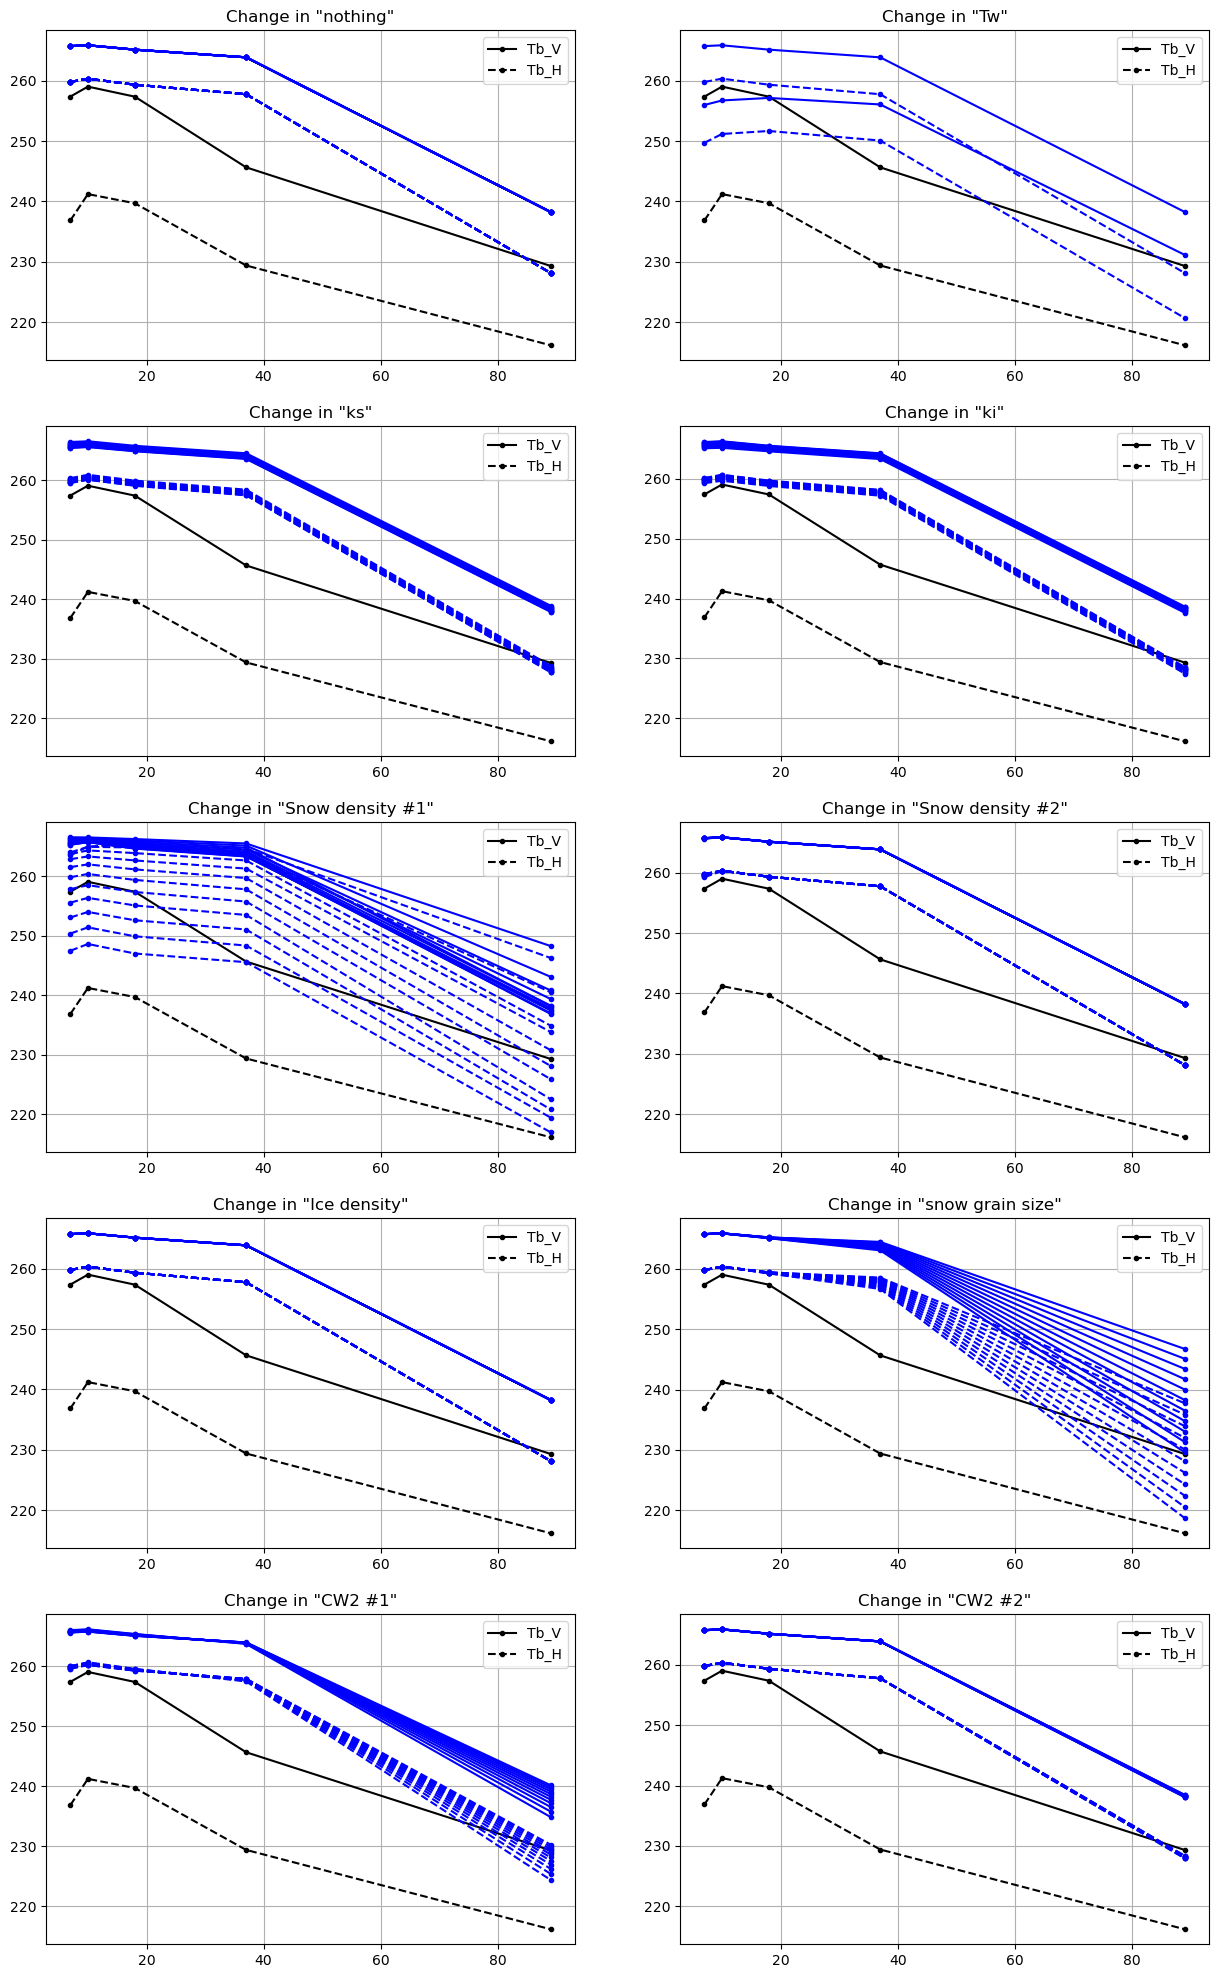

In [85]:
fig = plt.figure(figsize=(15,30))
freqs=np.array([7,10,18,37,89])

ChangeSize = np.arange(0.5, 1.6, 0.1).round(1)
#ChangeSize = np.arange(0.5, 1.6, 1.5).round(1)

Names = np.array(['nothing','Tw','ks','ki','Snow density #1','Snow density #2','Ice density', 'snow grain size','CW2 #1','CW2 #2'])

# Amount of variables to possibly change in profile maker
Changes = 10

TbV,TbH = tiepoint(snowDepth,iceThickness,surfTemp,iceConc)

for Type in range(Changes):
    
    plt.subplot(6,2,Type+1)
    plt.plot(freqs,TbV,'.-k', label = 'Tb_V')
    plt.plot(freqs,TbH,'.--k', label = 'Tb_H')

    ChangeArray = np.ones(Changes)
    
    
    for Size in range(len(ChangeSize)):
        
        ChangeArray[Type] = ChangeSize[Size]
        
        try:
            with suppress_stdout():
                smrtV,smrtH = run_smrt(snowDepth,iceThickness,surfTemp,ice_type,ChangeArray);
            plt.plot(freqs,smrtV,'.-b')
            plt.plot(freqs,smrtH,'.--b')
        
            score = abs(smrtV - TbV) + abs(smrtH - TbH)
            print('The mean score for change in {} by {}x is {:.2f}'.format(Type,ChangeSize[Size],np.mean(score)))
        
        except KeyboardInterrupt:
            break
        
        except:
            print('The mean score for change in {} by {}x FAILED !'.format(Type,ChangeSize[Size]))
            pass
    
    print(' ')
    plt.title('Change in "{}"'.format(Names[Type]))        
    plt.grid()
    plt.legend()
    

# Run until Errors

-- 1/10  Now Changing "nothing"  --
The mean score for change of 1x is 30.47
The mean score for change of 1.1x is 30.47
The mean score for change of 1.2x is 30.47
The mean score for change of 1.3x is 30.47
The mean score for change of 1.4x is 30.47
The mean score for change of 1.5x is 30.47
The mean score for change of 1.6x is 30.47
The mean score for change of 1.7x is 30.47
The mean score for change of 1.8x is 30.47
The mean score for change of 1.9x is 30.47
The mean score for change of 2.0x is 30.47
Reached the limit of change at ±100% 

The mean score for change of 0.9x is 30.47
The mean score for change of 0.8x is 30.47
The mean score for change of 0.7x is 30.47
The mean score for change of 0.6x is 30.47
The mean score for change of 0.5x is 30.47
The mean score for change of 0.4x is 30.47
The mean score for change of 0.3x is 30.47
The mean score for change of 0.2x is 30.47
The mean score for change of 0.1x is 30.47
The mean score for change of 0.0x is 30.47
Reached the limit of cha

C:\Users\fnifd\anaconda3\envs\Bachelor\lib\site-packages\smrt\rtsolver\dort.py:512: ComplexWarning: Casting complex values to real discards the imaginary part
  bmat[u+oi-oj-j, j+oj:j+oj+ldiag] = df[j::m+1][:ldiag]
C:\Users\fnifd\anaconda3\envs\Bachelor\lib\site-packages\smrt\rtsolver\dort.py:516: ComplexWarning: Casting complex values to real discards the imaginary part
  bmat[u+oi-oj+i, 0+oj:0+oj+ldiag] = df[i*m::m+1][:ldiag]


The mean score for change of 0.0x is 1076.95
Reached the limit of change at ±100% 

 
-- 7/10  Now Changing "Ice density"  --
The mean score for change of 1x is 30.47
The mean score for change of 1.1x is 30.47
The mean score for change of 1.2x is 30.47
The mean score for change of 1.3x is 30.47
The mean score for change of 1.4x is 30.47
The mean score for change of 1.5x is 30.47
The mean score for change of 1.6x is 30.47
The mean score for change of 1.7x is 30.47
The mean score for change of 1.8x is 30.47
The mean score for change of 1.9x is 30.47
The mean score for change of 2.0x is 30.47
Reached the limit of change at ±100% 

The mean score for change of 0.9x is 30.47
The mean score for change of 0.8x is 30.47
The mean score for change of 0.7x is 30.47
The mean score for change of 0.6x is 30.47
The mean score for change of 0.5x is 30.47
The mean score for change of 0.4x is 30.47
The mean score for change of 0.3x is 30.47
The mean score for change of 0.2x is 30.47
The mean score for c

C:\Users\fnifd\anaconda3\envs\Bachelor\lib\site-packages\smrt\permittivity\brine.py:198: RuntimeWarning: invalid value encountered in sqrt
  x = np.sqrt(s_r)


The mean score for change of 1x is 30.47
The mean score for change of 1.1x is 30.45
The mean score for change of 1.2x is 30.44
The mean score for change of 1.3x is 30.43
The mean score for change of 1.4x is 30.41
The mean score for change of 1.5x is 30.40
The mean score for change of 1.6x is 30.38
The mean score for change of 1.7x is 30.37
The mean score for change of 1.8x is 30.35
The mean score for change of 1.9x is 30.34
The mean score for change of 2.0x is 30.32
Reached the limit of change at ±100% 

The mean score for change of 0.9x is 30.48
The mean score for change of 0.8x is 30.50
The mean score for change of 0.7x is 30.51
The mean score for change of 0.6x is 30.52
The mean score for change of 0.5x is 30.54
The mean score for change of 0.4x is 30.55
The mean score for change of 0.3x is 30.56
The mean score for change of 0.2x is 30.58
The mean score for change of 0.1x is 30.59
The mean score for change of 0.0x is 30.60
Reached the limit of change at ±100% 

 


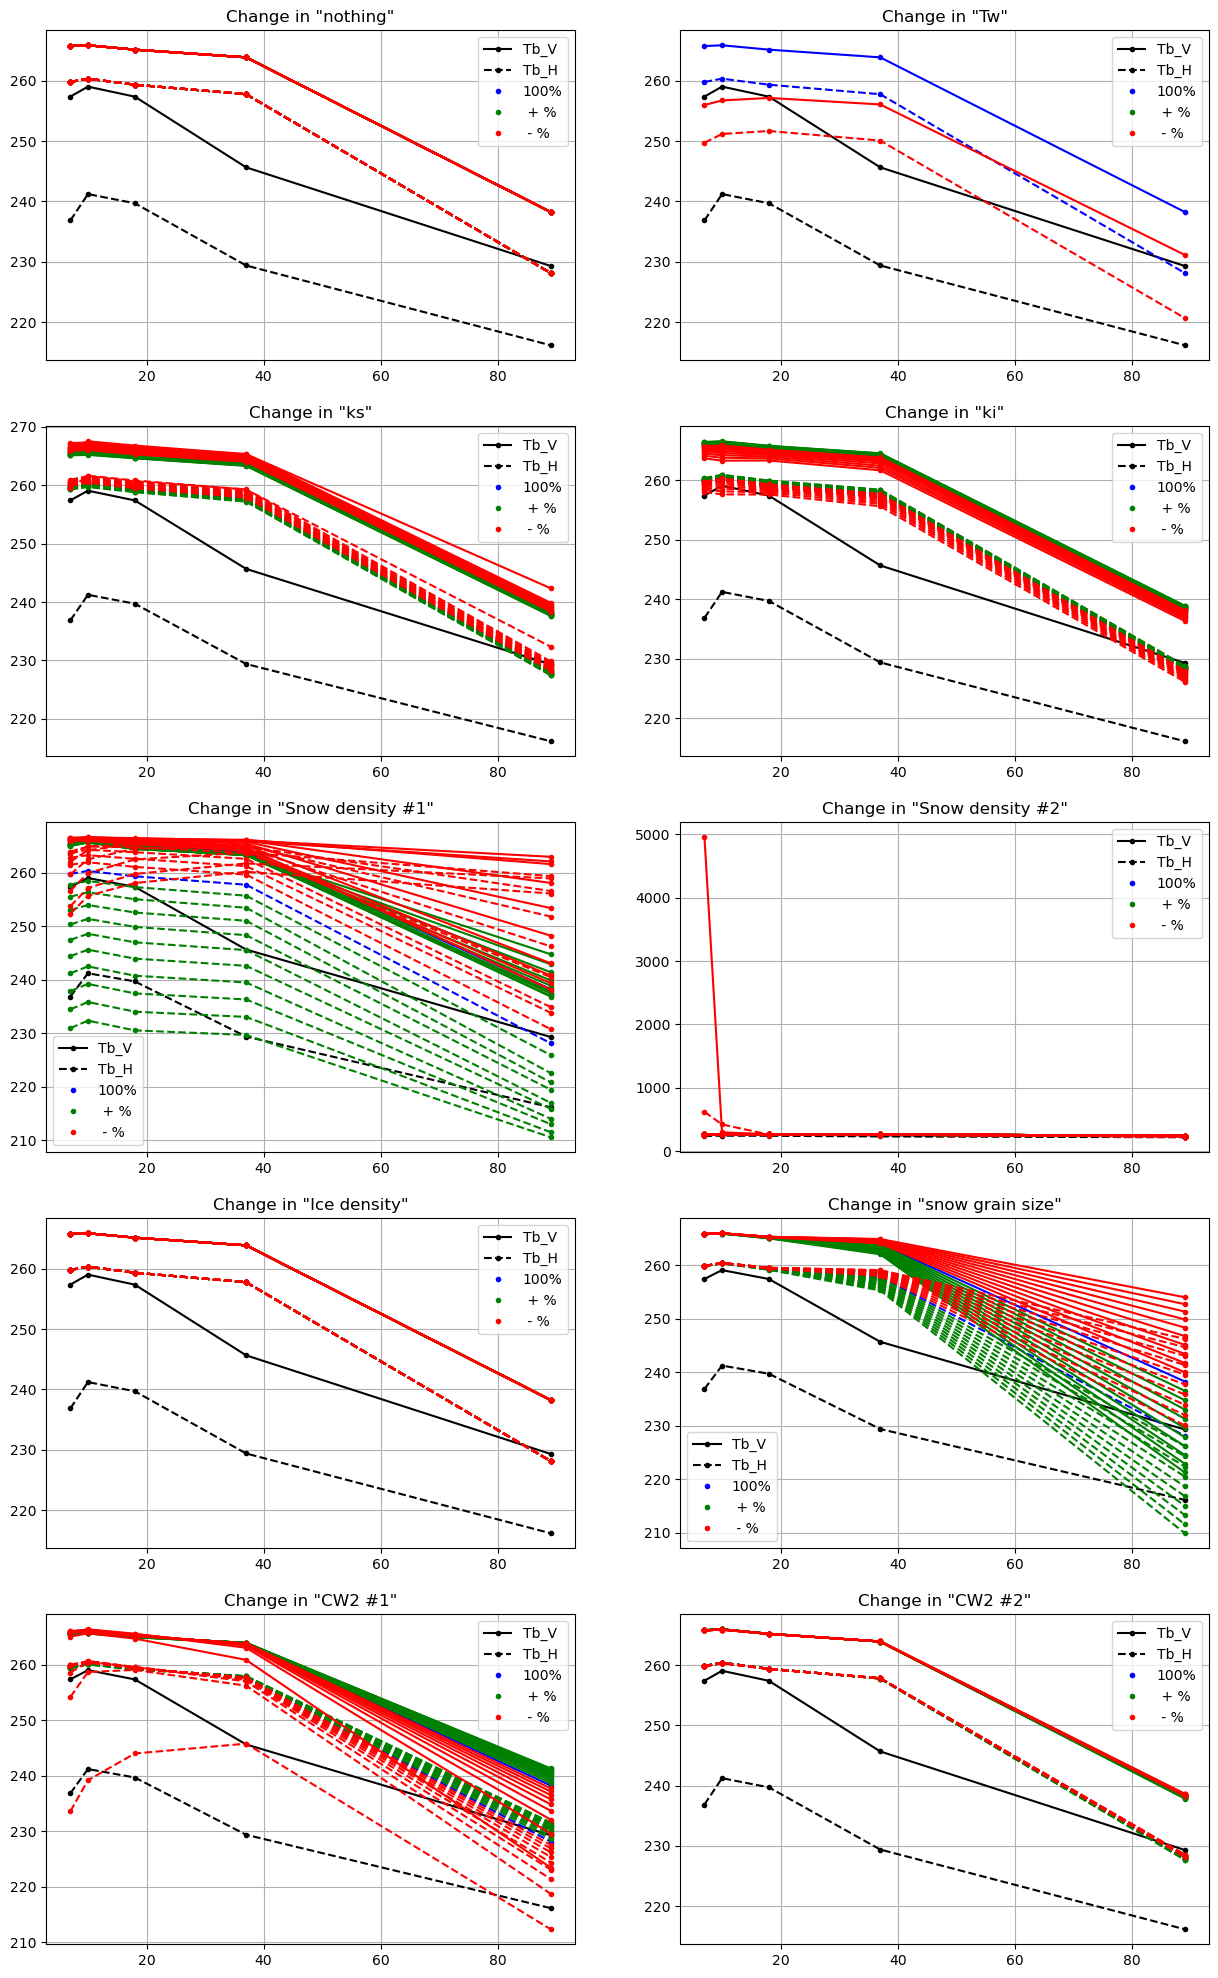

In [93]:
fig = plt.figure(figsize=(15,30))

# Pre-defined set of frequencies
freqs=np.array([7,10,18,37,89])

# Names of the different types of changes
Names = np.array(['nothing','Tw','ks','ki','Snow density #1','Snow density #2','Ice density', 'snow grain size','CW2 #1','CW2 #2'])

leaderboard = []     # Array for scores

Changes = 10         # Amount of variables to possibly change in profile maker
ChangeInterval = 0.1 # Step size between every size difference
limit = 1            # The amount that the step can go from the original value [2 means a max increase of (1+2)x]


# Array with different colors for plotting in the loop
colors = np.array(['b','g','r'])

# Run the basic tiepoint model, for use as reference
TbV,TbH = tiepoint(snowDepth,iceThickness,surfTemp,iceConc)

# Run loop for every changing variable 
for Type in range(Changes):
    
    print('-- {}/{}  Now Changing "{}"  --'.format(Type+1,Changes,Names[Type]))
    
    # Create a new subplot, and plot the reference tiepoint model
    plt.subplot(6,2,Type+1)
    plt.plot(freqs,TbV,'.-k', label = 'Tb_V')
    plt.plot(freqs,TbH,'.--k', label = 'Tb_H')

    # Creates/recreates a normal change array, with no changes
    ChangeArray = np.ones(Changes)
    
    # Reset values for next loop
    ChangeSize = 0
    dim = 0

    # Runs while the dimension is above or equal to -1
    # (Stops efter being reversed twice)
    while dim >= -1:

        # Uses the changing values for dimension and size to get an array of change
        Change = 1 + dim * ChangeSize
        ChangeArray[Type] = Change
        
        # Tries to run the SMRT model
        try:
            with suppress_stdout(): # Supress the output
                
                # runs SMRT and therefore also the profile creater
                smrtV,smrtH = run_smrt(snowDepth,iceThickness,surfTemp,ice_type,ChangeArray);
                
            # Plots the results from the SMRT (both vertical and horizontal)
            plt.plot(freqs,smrtV,'.-' + colors[dim])
            plt.plot(freqs,smrtH,'.--' + colors[dim])
              
            # Calculates a score by the difference between the SMRT and tiepoint values
            score = abs(smrtV - TbV) + abs(smrtH - TbH)
            print('The mean score for change of {}x is {:.2f}'.format(np.round(Change,2),np.mean(score)))
            leaderboard = np.append(leaderboard,np.mean(score)) # Adds the score to the leaderboard
            
            # Increase the change by the interval
            ChangeSize += ChangeInterval
            
            # Test for initial run conditians
            if dim == 0:
                # Set change direction to positive 
                dim = 1
            
            if np.round(ChangeSize,2) > limit:
                print('Reached the limit of change at ±{:}% \n'.format(limit*100))
                # Resets i and changes the change direction
                ChangeSize = ChangeInterval
                dim += -2
                
        # Allows for easier cancellation when running the whole loop        
        except KeyboardInterrupt:
            Type = Changes

        # Runs if/when the SMRT models gets an error
        # Skips that value and switch the change diraction to negative
        # If the direction is already negative this sitches to the next change parameter  
        except:
            print('Failed at calculating change in {} by {}x'.format(Type,np.round(Change,2)))
            # Resets ChangeSize and switch to negative change direction
            ChangeSize = ChangeInterval
            dim += -2
            pass
    

    print(' ')

    # Extra legend entries
    plt.plot([], [], '.' + colors[0], label="100%")
    plt.plot([], [], '.' + colors[1], label=" +%")
    plt.plot([], [], '.' + colors[2], label=" -%")
    
    # Plot settings
    plt.title('Change in "{}"'.format(Names[Type]))        
    plt.grid()
    plt.legend()    